# Formation RNAseq CEA - juin 2023

*Enseignantes : Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

# Part 11 : Overrepresentation and enrichment analysis

    0 - Getting started
        0. 1 - Setting up this R session on IFB core cluster  
        0. 2 - Parameters to be set or modified by the user   
    1 - Loading input data    
    2 - ORA using Enrichr   
    3 - Enrichment analysis with clusterProfiler (ORA + GSEA)
    4 - GSEA with the Java application
    5 - NGSEA
    6 - WGCNA
    7 - Saving our results for later use : RData file

---
## **Before going further**

<div class="alert alert-block alert-danger"><b>Caution:</b> 
Before starting the analysis, save a backup copy of this notebok : in the left-hand panel, right-click on this file and select "Duplicate"<br>
You can also make backups during the analysis. Don't forget to save your notebook regularly: <kbd>Ctrl</kbd> + <kbd>S</kbd> or click on the 💾 icon.
</div>

<div class="alert alert-block alert-warning"><b>Warning:</b>You are strongly advised to run the cells in the indicated order. If you want to rerun cells above, you can just restart the kernel to start at 1 again. </div>

---
---
## 0. Getting started

---
### 0.1 - Setting up this R session on IFB core cluster
---

<em>loaded JupyterLab</em> : Version 3.2.1

#### **0.1-a. Jupyter session**

In [1]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/jupyter/ {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,NODELIST -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Fri Oct  6 00:11:58 CEST 2023 ==="                         
[2] "          35432814      fast  jupyter cvandied  R    7:03:16      1 cpu-node-48"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                         
[4] "       JobID  AllocCPUS        NodeList "                                       
[5] "------------ ---------- --------------- "                                       
[6] "35432814              5     cpu-node-48 "                                       


__

#### **0.1-b. R session**

Next we load into this R session the various tools that we will use.   
***DO NOT worry*** if you see a large red output! It contains a warning message, including for functions from different packages sharing the same names. If some packages are required but not yet installed on the server, you will also see a message when the relevant packages are installed in your home directory ("~/R/x86_64-conda-linux-gnu-library/4.0").


In [2]:
## Code cell 2 ##

# list the required libraries from the CRAN repository
requiredLib <- c(
    "ggfortify",
    "ggrepel",
    "RColorBrewer",
    "ggplot2",
    "stringr",
    "matrixStats",
    "BiocManager",
    "ggnewscale"
)

# list the required libraries from the Bioconductor project
requiredBiocLib <- c("DESeq2",
                     "org.Mm.eg.db",
                     "clusterProfiler",
                     "enrichplot",
                     "ComplexHeatmap",
                     "ReactomePA")

# install required libraries if not yet installed
for (lib in requiredLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
    install.packages(lib, quiet = TRUE, repos = "https://cloud.r-project.org")
  }
}
for( lib in requiredBiocLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
  BiocManager::install(lib, quiet = TRUE, update = FALSE)
  }
}

# load libraries
message("Loading required libraries")
for (lib in requiredLib) {
  library(lib, character.only = TRUE)}
for (lib in requiredBiocLib) {
  library(lib, character.only = TRUE)}

# remove variables from the R session if they are no longer necessary 
rm(lib, requiredLib, requiredBiocLib)

Warning message:
“package ‘BiocManager’ was built under R version 4.0.5”
Bioconductor version '3.12' is out-of-date; the current release version '3.17'
  is available with R version '4.3'; see https://bioconductor.org/install


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, uniq

In [3]:
## Code cell 3 ##   

cat("Here is my R session with the loaded packages:\n")
sessionInfo()

Here is my R session with the loaded packages:


R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ReactomePA_1.34.0           ComplexHeatmap_2.6.2       
 [3] enrichplot_1.10.2           clusterProfiler_3.18.1     
 [5] org.Mm.eg.db_3.12.0         AnnotationDbi_1.52.0       
 [7] DESeq2_1.30.1               SummarizedExperiment_1.20.0
 [9] Bio

---

### 0.2 - Parameters to be set or modified by the user
---

- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

<div class="alert alert-block alert-warning"> <b> Warning on working directory: </b><br>In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened for the <b> fisrt time </b>. Even if you move it ton another directory, it keeps the original working diretory unless you set it again with the function <code>setwd()</code>.</div>

In [4]:
## Code cell 4 ##


gohome <- "/shared/projects/2312_rnaseq_cea/"
gohome

myfolder <- getwd()
myfolder


[1] "/shared/projects/2312_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck"

- With a `/` at the end, define the path to the folder where the results of this exploratory analysis will be stored. As it is a logical step usually performed together with the normalisation by `DESeq2`, we can stay in the same output folder :

In [5]:
## Code cell 5 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix

dir.create(paste(myfolder,"/Results/enrich/", sep = ""), recursive = TRUE)

# storing the path to this output folder in a variable
enrichfolder <- paste(myfolder,"/Results/enrich/", sep = "")
enrichfolder

# specifying the path to the folder with input data
deseq2folder <- paste(myfolder,"/Results/deseq2/", sep = "")
deseq2folder

# listing the content of the folder
print(system(paste("ls -hlt", deseq2folder), intern = TRUE) )

Warning message in dir.create(paste(myfolder, "/Results/enrich/", sep = ""), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/enrich' already exists”


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/enrich/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/deseq2/"

[1] "total 12M"                                                                                          
[2] "-rw-rw----+ 1 cvandiedonck cvandiedonck 1.6M Oct  5 21:08 deseq2_all_genes.RData"                   
[3] "-rw-rw----+ 1 cvandiedonck cvandiedonck 4.3M Oct  5 21:08 deseq2.RData"                             
[4] "-rw-rw----+ 1 cvandiedonck cvandiedonck 1.6M Oct  5 21:08 DESeq2_significant_genes-0_05.tsv"        
[5] "-rw-rw----+ 1 cvandiedonck cvandiedonck 4.5M Oct  5 20:22 deseq2-final.RData"                       
[6] "-rw-rw----+ 1 cvandiedonck cvandiedonck 2.4K Oct  5 20:22 DESeq2_significant_genes-0_00001-down.tsv"
[7] "-rw-rw----+ 1 cvandiedonck cvandiedonck 4.1K Oct  5 20:22 DESeq2_significant_genes-0_00001-up.tsv"  


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [6]:
## Code cell 6 ##

options(repr.plot.width = 15, repr.plot.height = 10) # for figure display in the notebook

---
---
## 1 - Input data
---

### 1.1 - Loading input data and metadata
---

Before loadingg any data, let's check what we have in our session.

In [7]:
## Code cell 7 ##

ls()

[1] "deseq2folder"       "enrichfolder"       "gohome"            
[4] "myfolder"           "session_parameters"

#### **1.1-a. Genes of interest**

We now need to retrieve the lists of genes of interest that we generated in the previous session.   
These genes could be either:
- genes that are clustered together in unsupervised clustering
- genes that present a correlated (and/or anti-correlated) expression
- up-regulated DE genes
- down-regulated DE genes
- up- and down- regulated DE genes together

As we stored some of these lists at the end of Pipe_10, we can simply reload all our information by opening them.  

In [8]:
## Code cell 8 ##

rdata <- paste0(deseq2folder, "deseq2-final.RData")
rdata
load(rdata, verbose = TRUE)

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/deseq2/deseq2-final.RData"

Loading objects:
  dup_genes
  norm_counts
  upGenes
  deseq2folder
  gohome
  alpha
  samples
  top50DE
  conditionColor
  session_parameters
  top50var
  for_factominer
  .pbd_env
  res2_dHet_dHetRag_sig_ranked_annot
  downGenes
  eig.val
  .Random.seed
  var_genes
  gencode
  myfolder
  PCAres


We notice that when loading `deseq2-final.RData` we loaded `deseq2folder` and `gohome` objects. Fortunately they are the same as the ones we assigned before. 

In [9]:
## Code cell 9 ##

deseq2folder
gohome

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/deseq2/"

[1] "/shared/projects/2312_rnaseq_cea/"

We can now list all the object we have currently in our session: 

In [10]:
## Code cell 10 ##

ls()

[1] "alpha"                              "conditionColor"                    
 [3] "deseq2folder"                       "downGenes"                         
 [5] "dup_genes"                          "eig.val"                           
 [7] "enrichfolder"                       "for_factominer"                    
 [9] "gencode"                            "gohome"                            
[11] "myfolder"                           "norm_counts"                       
[13] "PCAres"                             "rdata"                             
[15] "res2_dHet_dHetRag_sig_ranked_annot" "samples"                           
[17] "session_parameters"                 "top50DE"                           
[19] "top50var"                           "upGenes"                           
[21] "var_genes"

Among them, we have sereval sets of genes:

- `top50DE`: with the top50 DE genes and their summary statistics

In [11]:
## Code cell 11 ##

str(top50DE)

'data.frame':	50 obs. of  18 variables:
 $ ensemblID     : 'AsIs' chr  "ENSMUSG00000076621.2" "ENSMUSG00000024241.8" "ENSMUSG00000117613.3" "ENSMUSG00000076618.2" ...
 $ baseMean      : num  1157 5715 1666 318 191 ...
 $ log2FoldChange: num  -9.14 5.01 7.61 -4.13 -5.93 ...
 $ lfcSE         : num  0.272 0.208 0.336 0.186 0.276 ...
 $ stat          : num  -33.6 24.1 22.6 -22.2 -21.5 ...
 $ pvalue        : num  8.31e-248 1.53e-128 1.90e-113 4.85e-109 1.01e-102 ...
 $ padj          : num  1.72e-243 1.58e-124 1.31e-109 2.51e-105 4.18e-99 ...
 $ chr           : chr  "chr12" "chr17" "chr18" "chr12" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  1.13e+08 8.07e+07 1.53e+07 1.13e+08 1.13e+08 ...
 $ end           : num  1.13e+08 8.08e+07 1.54e+07 1.13e+08 1.13e+08 ...
 $ strand        : chr  "-" "-" "+" "-" ...
 $ gene_type     : chr  "IG_J_gene" "protein_coding" "lncRNA" "IG_J_gene" ...
 $ gene_name     : chr  "Ighj1" "Sos1" "Gm2629" "Ighj4" ...
 $ le

- `downGenes`: list of all downregulated genes at an adjusted pvalue of 10-5

In [12]:
## Code cell 12 ##

str(downGenes)

'data.frame':	326 obs. of  18 variables:
 $ ensemblID     : 'AsIs' chr  "ENSMUSG00000076621.2" "ENSMUSG00000076618.2" "ENSMUSG00000076620.3" "ENSMUSG00000084081.4" ...
 $ baseMean      : num  1157 318 191 408 268 ...
 $ log2FoldChange: num  -9.14 -4.13 -5.93 -6.25 -5.46 ...
 $ lfcSE         : num  0.272 0.186 0.276 0.311 0.284 ...
 $ stat          : num  -33.6 -22.2 -21.5 -20.1 -19.2 ...
 $ pvalue        : num  8.31e-248 4.85e-109 1.01e-102 6.44e-90 2.10e-82 ...
 $ padj          : num  1.72e-243 2.51e-105 4.18e-99 1.90e-86 5.26e-79 ...
 $ chr           : chr  "chr12" "chr12" "chr12" "chr11" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  1.13e+08 1.13e+08 1.13e+08 2.27e+07 1.20e+08 ...
 $ end           : num  1.13e+08 1.13e+08 1.13e+08 2.27e+07 1.20e+08 ...
 $ strand        : chr  "-" "-" "-" "-" ...
 $ gene_type     : chr  "IG_J_gene" "IG_J_gene" "IG_J_gene" "processed_pseudogene" ...
 $ gene_name     : chr  "Ighj1" "Ighj4" "Ighj2" "Gm12057"

- `upGenes`: list of all upregulated genes at an adjusted pvalue of 10-5

In [13]:
## Code cell 13 ##

str(upGenes)

'data.frame':	590 obs. of  18 variables:
 $ ensemblID     : 'AsIs' chr  "ENSMUSG00000024241.8" "ENSMUSG00000117613.3" "ENSMUSG00000070348.6" "ENSMUSG00000025232.9" ...
 $ baseMean      : num  5715 1666 5630 1811 1097 ...
 $ log2FoldChange: num  5.01 7.61 7.05 2.65 8.32 ...
 $ lfcSE         : num  0.208 0.336 0.348 0.138 0.467 ...
 $ stat          : num  24.1 22.6 20.3 19.2 17.8 ...
 $ pvalue        : num  1.53e-128 1.90e-113 2.78e-91 2.29e-82 4.36e-71 ...
 $ padj          : num  1.58e-124 1.31e-109 9.58e-88 5.26e-79 7.52e-68 ...
 $ chr           : chr  "chr17" "chr18" "chr7" "chr9" ...
 $ annotation    : chr  "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
 $ start         : num  8.07e+07 1.53e+07 1.44e+08 5.94e+07 3.46e+07 ...
 $ end           : num  8.08e+07 1.54e+07 1.44e+08 5.95e+07 3.48e+07 ...
 $ strand        : chr  "-" "+" "-" "+" ...
 $ gene_type     : chr  "protein_coding" "lncRNA" "protein_coding" "protein_coding" ...
 $ gene_name     : chr  "Sos1" "Gm2629" "Ccnd1" "Hexa" ...
 $ lev

<span style="color:red">Of note, we also saved in `./Results/deseq2/` two text files with only the `gene_name` column of the top and down regulated genes.</span>

In [14]:
## Code cell 14 ##

print(list.files("./Results/deseq2/", pattern = "DESeq2_significant_genes-0_00001"))

[1] "DESeq2_significant_genes-0_00001-down.tsv"
[2] "DESeq2_significant_genes-0_00001-up.tsv"  


#### **1.1-b. Expressed genes**

We still need one file with all expressed genes (for ORAs) and with their summary statistics (for GSEA). Let's load the saved file of all genes after Deseq2 analysis.

In [15]:
## Code cell 15 ##

rdata <- paste0(deseq2folder, "deseq2_all_genes.RData")
rdata
load(rdata, verbose = TRUE)

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/cvandiedonck/Results/deseq2/deseq2_all_genes.RData"

Loading objects:
  res_dHet_dHetRag_annot


We don't need anything else from the previous session, so we can remove the other objects from our current R session, in order to save memory.

In [16]:
## Code cell 16 ##

rm(alpha, conditionColor, dup_genes, eig.val, for_factominer, gencode, norm_counts,
  PCAres, rdata, res2_dHet_dHetRag_sig_ranked_annot, samples, top50var, var_genes)  
ls()

[1] "deseq2folder"           "downGenes"              "enrichfolder"          
[4] "gohome"                 "myfolder"               "res_dHet_dHetRag_annot"
[7] "session_parameters"     "top50DE"                "upGenes"

---
---
## 2 - Over Representation analysis (ORA)
---

### 2.1. Principle of Overrepresentation analysis (ORA)
---

Most of the time in our biological studies, we start from the hypothesis that a biological process is the result of the action of multiple genes sharing a common fonctionnality, and that genes that are activated or repressed in a concerted manner share common features or belong to the same pathway. Therefore, we need to find if our list of genes of interest contains genes that have these common features in a number exceeding what is expected by mere chance *(i.e the number of genes with this features that is obtained by random sampling your genome of interest)*.  

**Over-representation analysis** is a statistical method to determine whether genes from pre-defined sets (ex: those possessing a specific GO term or belonging to a given biological pathway) are indeed present more than would be expected by chance (i.e are over-represented) in a list of genes of interest. In a transcriptomic analysis, this list can be your set of under- or over- expressed genes.    

<div class="alert alert-block alert-warning"> <b> Warning : </b><br>You can also find this method under the name of Gene Set Enrichment Analysis, but this can be confusing, because this name is the same as another method that does not rely on a list of genes (see below). Therefore, the name of Over-representation analysis is to be prefered.</div>   

In this method, you compare your list of genes to a variety of pre-established gene sets, such as a list of kinases or the known targets of a given transcription factor. The statistical test is a hypergeometric test, that estimates the significance of the overlap between your list and the pre-defined list, by comparing this overlap to those obtained with random samples of the same size from the same genome. If your list of genes of interest contains an overlap superior to what is expected by chance, it is considered as enriched for the tested feature, and an enrichment p-value is provided. As for other statistical tests in biological studies, this p-value has to be corrected to account for multiple testing, thus you have to analyse your results using the adjusted p-value.



---
### 2.2. Overrepresentation analysis (ORA) using Enrichr 
---


ORA is widely used in transcriptomic analysis, and the tools to perform ORAs are numerous. One of the most practical and complete ones is **Enrichr**, developped by the Ma'ayan lab. The tool has a very simple and user-friendly web interface, and provide a very large number of results, grouped in 5 main categories: Transcription, Pathways, Ontologies, Disease/Drugs and Cell Types, each with numerous interrogated lists within, plus an additional Misc for various info, and a Legacy one with older lists.   
In total, 218 lists are tested against your set of genes at once, for human and murine gene lists.    
   
The **Enrichr** tool is found here:
https://maayanlab.cloud/Enrichr/

There are companion web tools for other models (fly, yeast worm and fish) there: https://maayanlab.cloud/modEnrichr/   

Usually, you perform ORA with a simple list of genes of interest, for example DE genes. When doing this, all the genes in the list are considered as providig equal information. For a more biological context, **genes can be analysed with a numerical value** that assess their relevance in the study. For transcriptomic analysis, we can use the fold-change, that will provide more weight to genes that are highly deregulated.   
In addition, by default analysis consider the same genomic background for all studies. Again, a more correct approach is to take account the biological context of your study, i.e all the genes that are *expressed* in your cells. This is possible using the new ***adding a background*** feature of **Enrichr**.    
Finally, you can create an account to keep your lists for further retrieval, but it is not required.  

<mark>@Sandrine: tu veux mettre du code ici?</mark>

---
---
## 3. Enrichment analysis with `clusterProfiler`
---

There are two main packages to study gene sets enrichment in R.

- [gprofiler2](https://cran.r-project.org/web/packages/gprofiler2/index.html): a CRAN packages to do similar analyses as in the web interface of [G:Profiler](https://biit.cs.ut.ee/gprofiler/gost)

- [clusterProfiler](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) available in Bioconductor.

**clusterProfiler** is by far the most complete and flexible tool to perform ***ORAs (Over-Representation Analyses)*** that are single-gene enrichment methods, or to perform ***SAFE (Significance Analysis of Function and Expression)*** like GSEA.

Its guide is available at both these links:
- https://bioconductor.org/packages/release/bioc/vignettes/clusterProfiler/inst/doc/clusterProfiler.html
- https://yulab-smu.top/biomedical-knowledge-mining-book/index.html

---
### 3.1. ORA
---

**clusterProfiler** can be used for several ORAs on different datasets: Gene Ontology (GO), Kyoto Encyclopedia of Genes and Genomes (KEGG), Reactome, Disease Ontology (DO), Disease Gene Network (DisGeNET), wikiPathways, Molecular Signatures Database (MSigDb) and custom datasets.

We will illustrate clusterProfiler usage on GO, Reactome and KEGG.

#### **3.1-a. GO**

clusterProfiler needs **a set of unique genes**.

Let's use the top 50 DE genes.

In [17]:
# Code cell 17 ##

mygenes <- unique(top50DE$gene_name) 

The function to run it for GO ebrichment is `enrichGO()`. For the `ont` (Ontology) argument, we can specify either molecular function ("MF"), cellular components ("CC"), biological processes ("BP") or "ALL".

Here we use `org.Mm.eg.db` as the database collecting all genes for the mouse genome with their different identifiers. This database is available in a bioconductor package: http://bioconductor.org/packages/release/data/annotation/html/org.Mm.eg.db.html

Bioconductor has already provided OrgDb for about 20 species. If your  specie of interest is not available, see [here](https://yulab-smu.top/biomedical-knowledge-mining-book/GOSemSim.html#gosemsim-supported-organisms).

<div class="alert alert-block alert-danger"><b>Caution:</b> 
When performing enrichment analyses, you should not run the analysis againts all genes in the genome, but only on the subset of expressed genes in your samples. We call it the <b> universe</b>. Here we select all unique expressed genes.
<br>
For the `keyType` in GO enrichment, we can use the genes SYMBOL rather than the ENSEMBL or ENTREZID.
    
The `minGSize` and `maxGsize` are parameters to set up the min and max of number of genes to be part of a gene set to be tested.   
Finally, we select statistical parameters: a pvalueCutoff after an adjustment for multiple testing.
</div>    

In [18]:
# Code cell 18 #

enr_go <- enrichGO(gene = mygenes, 
             ont ="ALL", 
             OrgDb = org.Mm.eg.db,
             universe = unique(res_dHet_dHetRag_annot$gene_name),
             keyType = "SYMBOL", 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.1, 
             pAdjustMethod = "BH")

<mark> Be patient, the above command can last a minute or so </mark>

We can visualize for example to top 20 enrichments:

In [19]:
# Code cell 19 #

head(enr_go, 20)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0072509,MF,GO:0072509,divalent inorganic cation transmembrane transporter activity,4/39,116/14377,0.0002661166,0.04430001,0.02990276,Erc1/Ryr2/Slc30a4/Slc39a11,4
GO:0015075,MF,GO:0015075,ion transmembrane transporter activity,7/39,555/14377,0.0006452521,0.04430001,0.02990276,Erc1/Ryr2/Mfsd10/Slc1a5/Slc30a4/Gria2/Slc39a11,7
GO:0008324,MF,GO:0008324,cation transmembrane transporter activity,6/39,407/14377,0.0007332183,0.04430001,0.02990276,Erc1/Ryr2/Slc1a5/Slc30a4/Gria2/Slc39a11,6
GO:0046873,MF,GO:0046873,metal ion transmembrane transporter activity,5/39,272/14377,0.0007946189,0.04430001,0.02990276,Erc1/Ryr2/Slc30a4/Gria2/Slc39a11,5
GO:0005385,MF,GO:0005385,zinc ion transmembrane transporter activity,2/39,18/14377,0.0010673678,0.04760460,0.03213339,Slc30a4/Slc39a11,2
GO:0022857,MF,GO:0022857,transmembrane transporter activity,7/39,679/14377,0.0020848982,0.07748872,0.05230534,Erc1/Ryr2/Mfsd10/Slc1a5/Slc30a4/Gria2/Slc39a11,7
GO:0015318,MF,GO:0015318,inorganic molecular entity transmembrane transporter activity,6/39,520/14377,0.0025696261,0.08186095,0.05525662,Erc1/Ryr2/Slc1a5/Slc30a4/Gria2/Slc39a11,6
GO:0022890,MF,GO:0022890,inorganic cation transmembrane transporter activity,5/39,367/14377,0.0029748268,0.08292330,0.05597372,Erc1/Ryr2/Slc30a4/Gria2/Slc39a11,5
GO:0046915,MF,GO:0046915,transition metal ion transmembrane transporter activity,2/39,34/14377,0.0038080073,0.09435396,0.06368948,Slc30a4/Slc39a11,2


**Several nice plots can be drawn** as described in Chapter 15 of the manual: http://yulab-smu.top/biomedical-knowledge-mining-book/enrichplot.html.

Among available plots, we can draw:

- **barplots** is the most widely used vizualization. It depict the enrichment scores (e.g. p values) and gene counts or ratio as bars whose length and color are proportional to the number of enriched genes.

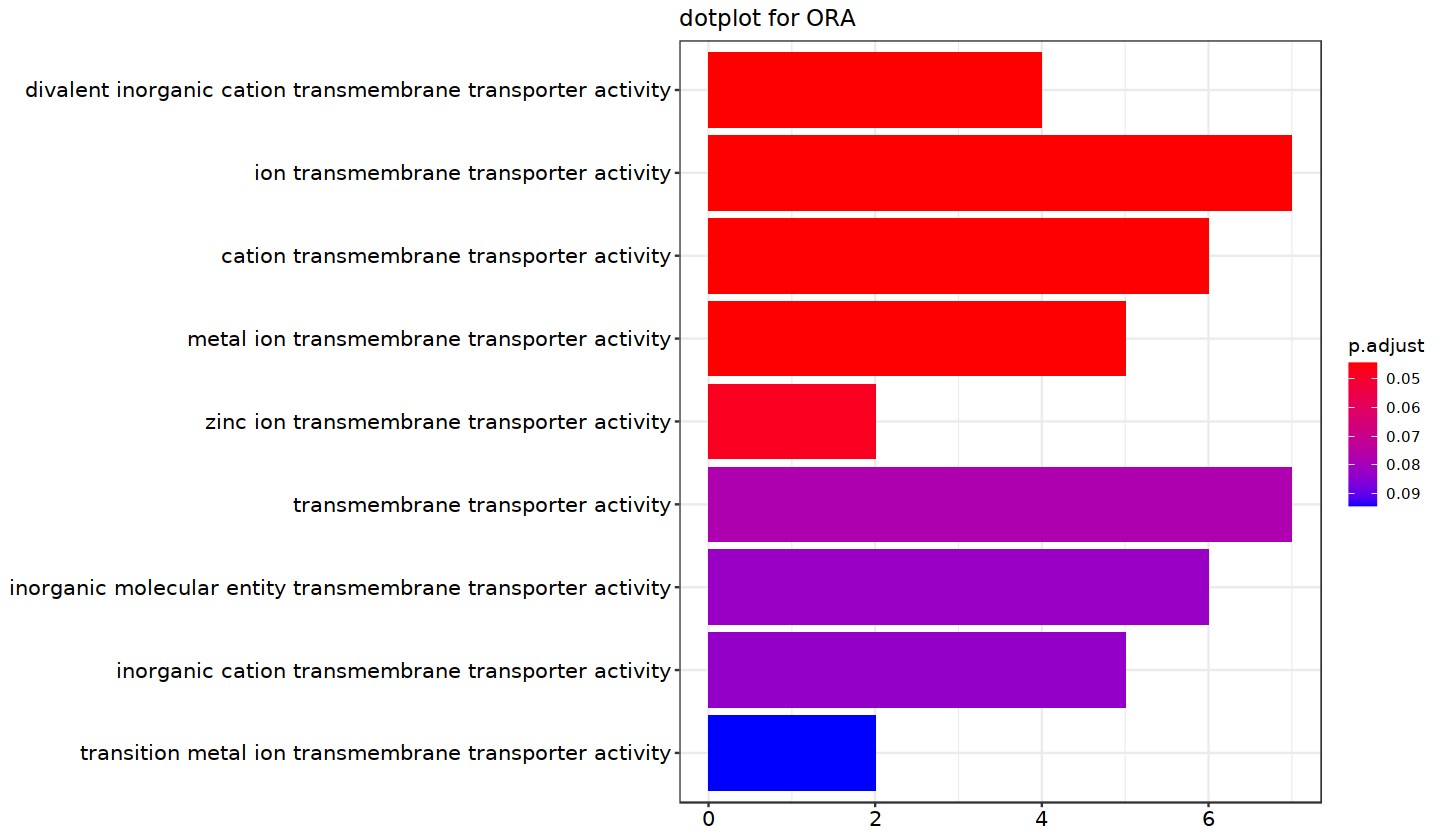

In [20]:
# Code cell n°20

options(repr.plot.width = 12, repr.plot.height = 7)
barplot(enr_go, showCategory = 20,
        label_format = function(x) stringr::str_wrap(x, width = 120)) + #to be able to see terms description in a single row : play on the number (eg. 120)
        ggtitle("dotplot for ORA") ## uses ggplot2 you will see in session 4

- **dotplots** that depict the enrichment scores (e.g. p values) and gene counts or ratio as dots whose size is proportional to the number of enriched genes. By default they are sorted by incerasing p adjust pvalue.

wrong orderBy parameter; set to default `orderBy = "x"`



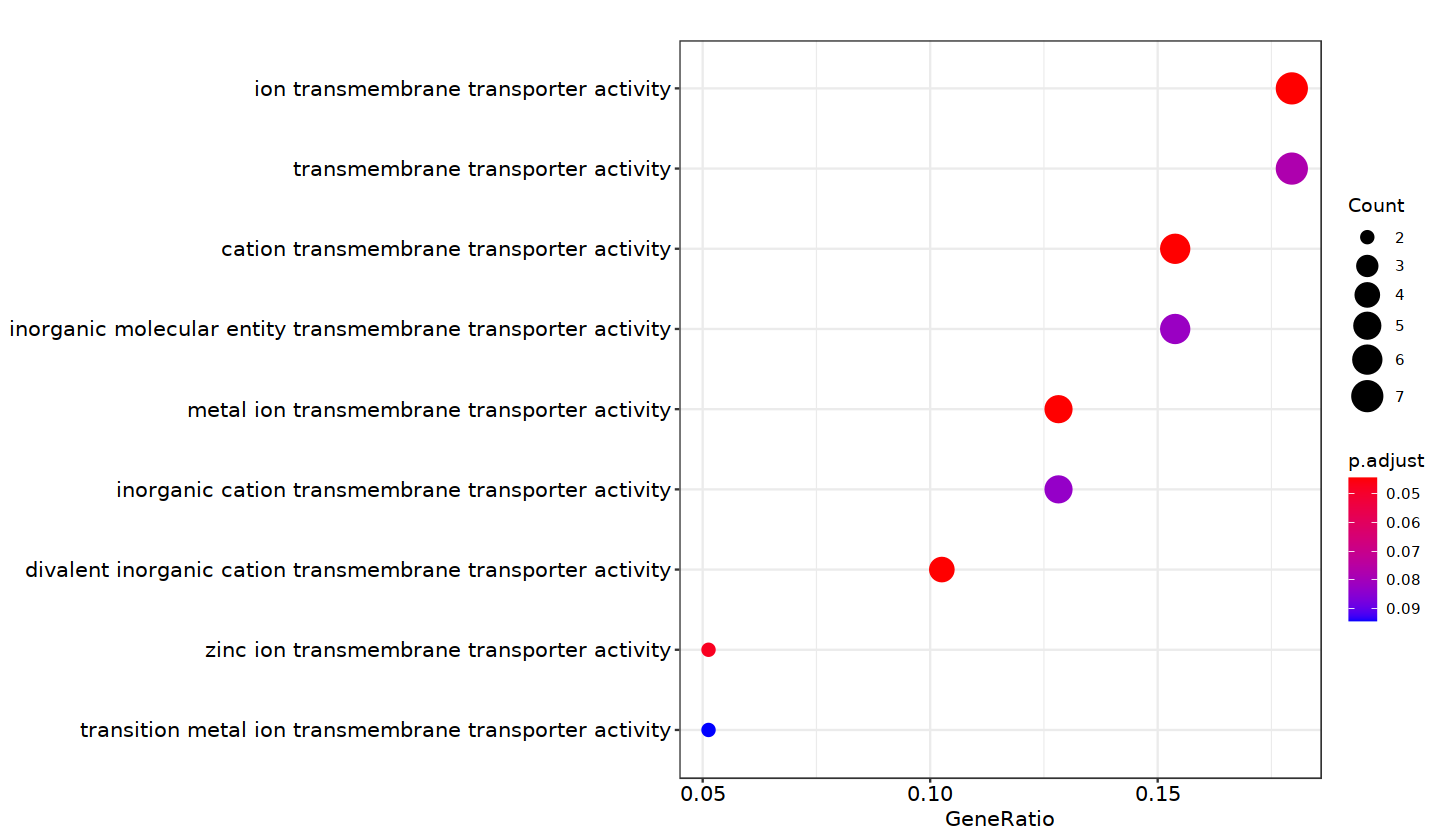

In [21]:
# Code cell n°21

options(repr.plot.width = 12, repr.plot.height = 7)
dotplot(enr_go,
        showCategory=20)
        label_format = function(x) stringr::str_wrap(x, width=120) +
        ggtitle("dotplot for ORA")

- **emapplots (enrichment map plots)**: Enrichment map organizes enriched terms into a network with edges connecting overlapping gene sets. In this way, mutually overlapping gene sets tend to cluster together, making it easy to identify functional module.

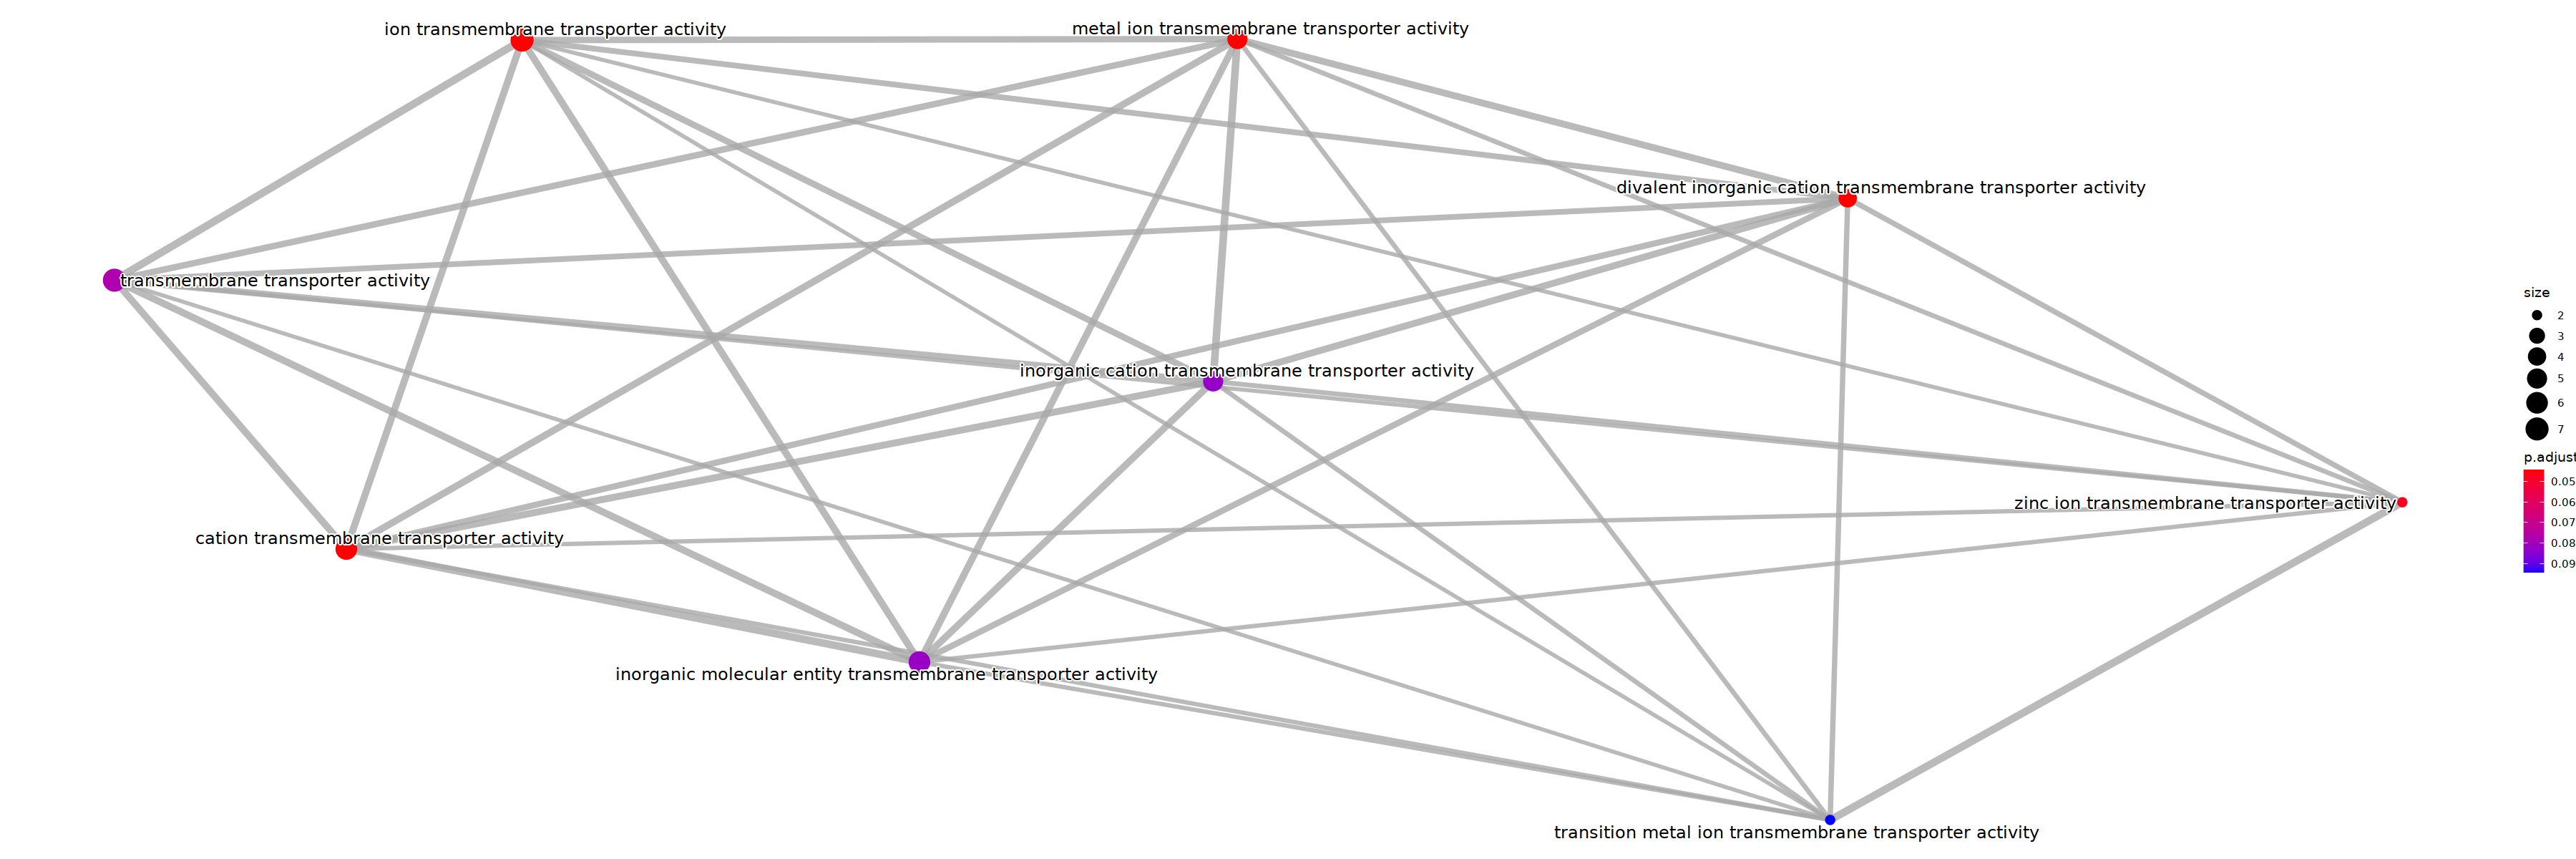

In [22]:
# Code cell n°22

options(repr.plot.width = 30, repr.plot.height= 10)
enr_go <- enrichplot::pairwise_termsim(enr_go, method = "JC", semData = "org.Mm.eg.db")
emapplot(enr_go, showCategory = 20)

<mark> Do not hesitate to rerun the above command if the figure displayed is not readable. The layout changes every time it is run.</mark>

- **treeplots**: displays a hierarchical clustering of enriched terms (after pairwise step in previous cell)

In the clusterProfiler version installed at the IFB, the treeplot() function is not yet present ine the package. If you are working with a more recent version, the command would be the following:

- **upsetplots**: displays the association between genes and gene sets. It emphasizes the gene overlapping among different gene sets.

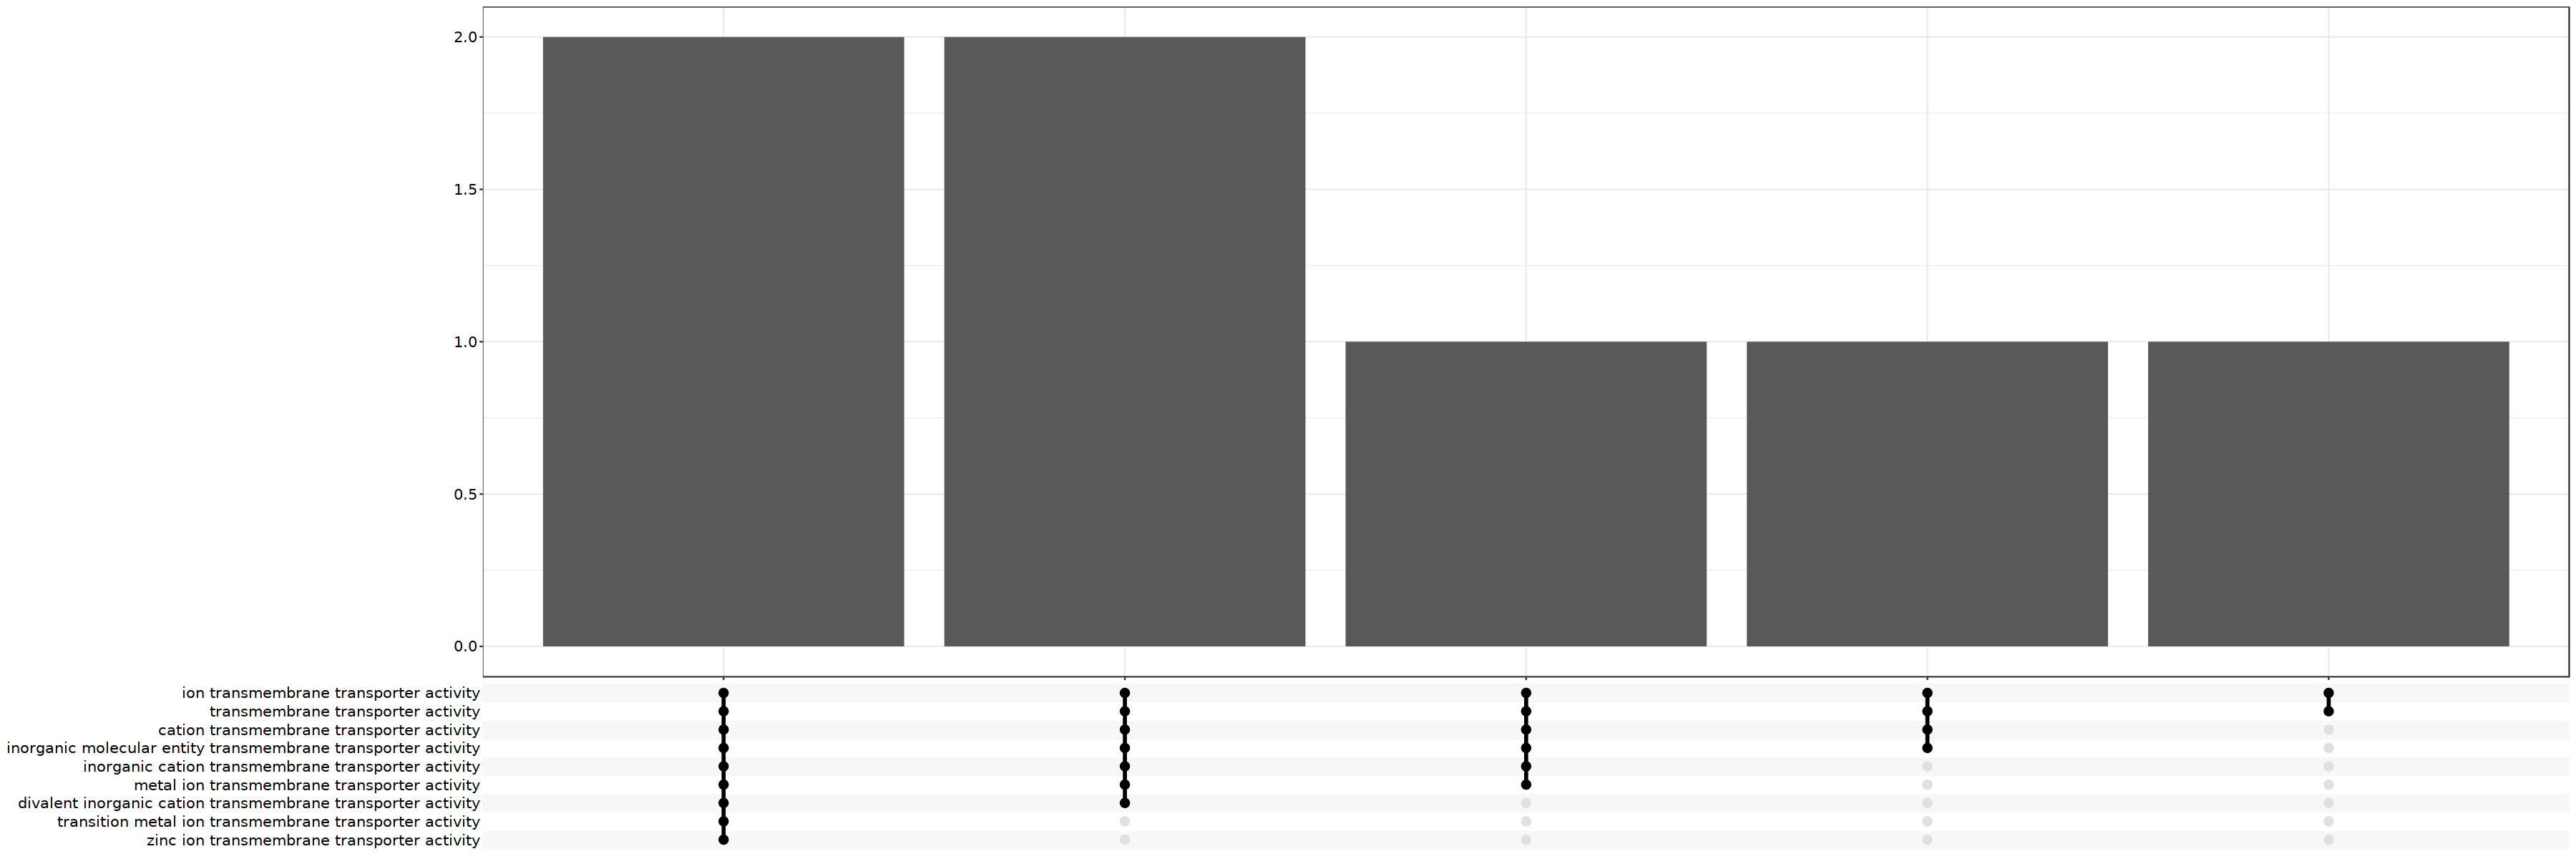

In [23]:
# Code cell n°23

upsetplot(enr_go)

- **cne plots**: depict the linkages of genes and biological concepts (e.g. GO terms or KEGG pathways) as a network.

One plot often generated like the upsetplot is the cnetplot that depicts the linkages of genes and biological concepts (e.g. GO terms or KEGG pathways) as a network.

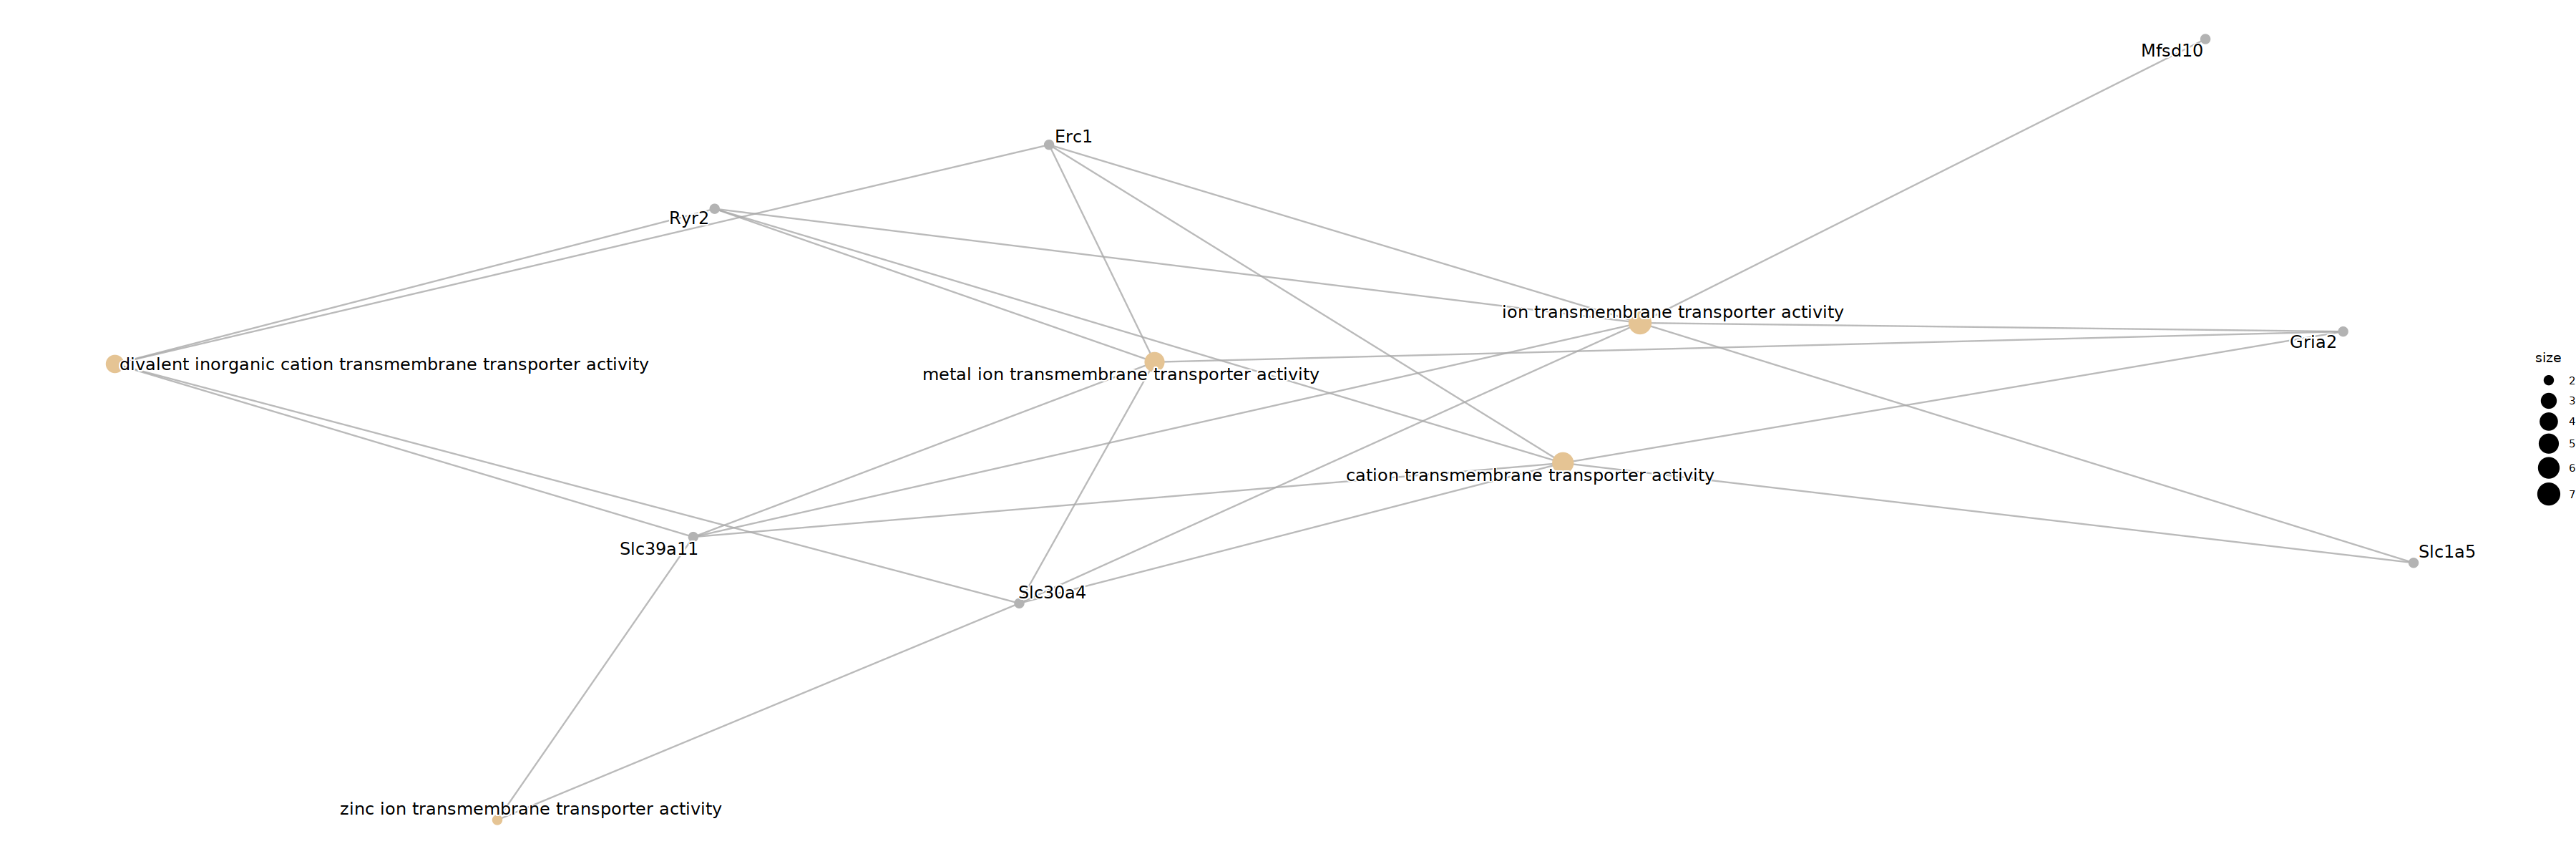

In [24]:
# Code cell n°24

cnetplot(enr_go, categorySize ="pvalue", showCategory = 5)

There are many more plots available. The package clusterProfiler is in constant development with new plots. 

#### **3.1-b. Reactome**

Similarly, we can run the ORA on Reactome pathways. It uses the gene Entrez IDs rather than the gene symbols. So we have to get them.
The function `bitr()` generates the correspondance when available.

In [25]:
# Code cell n°25

mygenes_entrezid <- clusterProfiler::bitr(mygenes, fromType = 'SYMBOL', toType = 'ENTREZID', OrgDb = 'org.Mm.eg.db')
mygenes_entrezid

'select()' returned 1:1 mapping between keys and columns

Warning message in clusterProfiler::bitr(mygenes, fromType = "SYMBOL", toType = "ENTREZID", :
“6% of input gene IDs are fail to map...”


,SYMBOL,ENTREZID
,<chr>,<chr>
1,Ighj1,777648
2,Sos1,20662
3,Gm2629,100040151
4,Ighj4,777656
5,Ighj2,777654
6,Ccnd1,12443
7,Gm12057,100042846
8,Erc1,111173
9,Hexa,15211


With a 10% FDR, we retrieve no pathway here. So to show you the command, we incerase it at 20%.

In [26]:
# Code cell n°26

enr_react <- enrichPathway(gene = mygenes_entrezid$ENTREZID, organism = "mouse", pvalueCutoff = 0.20, readable = TRUE)
head(enr_react)


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-MMU-1483206,R-MMU-1483206,Glycerophospholipid biosynthesis,2/13,115/8733,0.01219640,0.1351857,0.09412018,Gpam/Pcyt1a,2
R-MMU-70635,R-MMU-70635,Urea cycle,1/13,10/8733,0.01479432,0.1351857,0.09412018,Ass1,1
R-MMU-74749,R-MMU-74749,Signal attenuation,1/13,10/8733,0.01479432,0.1351857,0.09412018,Sos1,1
R-MMU-8983432,R-MMU-8983432,Interleukin-15 signaling,1/13,11/8733,0.01626258,0.1351857,0.09412018,Sos1,1
R-MMU-167044,R-MMU-167044,Signalling to RAS,1/13,12/8733,0.01772882,0.1351857,0.09412018,Sos1,1
R-MMU-179812,R-MMU-179812,GRB2 events in EGFR signaling,1/13,12/8733,0.01772882,0.1351857,0.09412018,Sos1,1


You can draw any figures as above.

wrong orderBy parameter; set to default `orderBy = "x"`



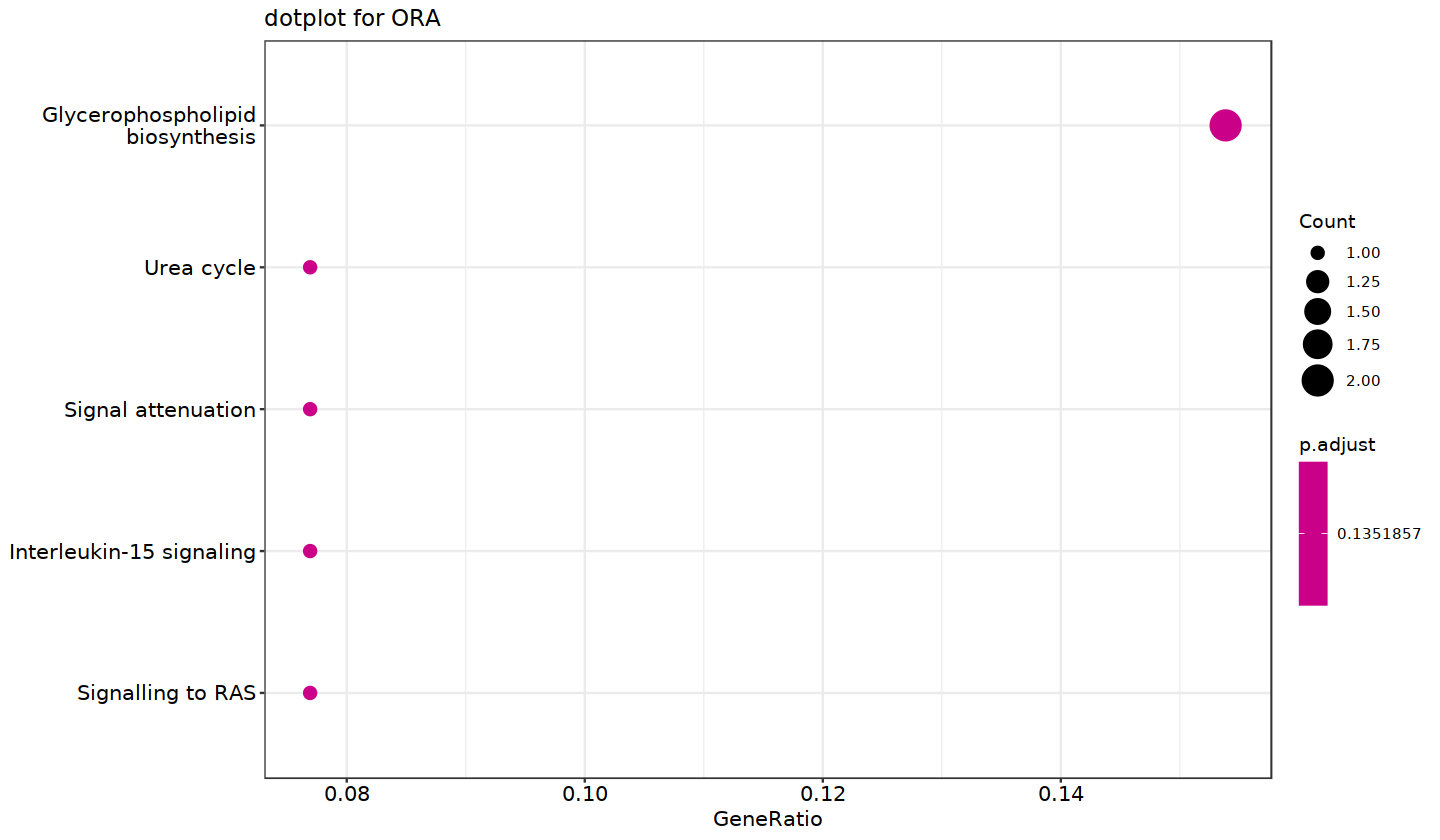

In [27]:
# Code cell n°27

options(repr.plot.width = 12, repr.plot.height = 7)
dotplot(enr_react,
        showCategory = 5)+
        ggtitle("dotplot for ORA")

#### **3.1-c. KEGG**

Similarly, we can run the ORA on KEGG pathways. The trick here is not to use gene name symbols, nor Gene IDs but their matching Uniprot IDs. The function `bitr()` generates the correspondance when available.

In [45]:
# Code cell n°28

mygenes_uniprot <- clusterProfiler::bitr(mygenes, fromType = 'SYMBOL', toType = 'UNIPROT', OrgDb = 'org.Mm.eg.db')
mygenes_uniprot

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(mygenes, fromType = "SYMBOL", toType = "UNIPROT", :
“22% of input gene IDs are fail to map...”


,SYMBOL,UNIPROT
,<chr>,<chr>
1,Zfp992,B1ASD8
2,Stag3,O70576
3,Spr,Q91XH5
4,Sos1,Q3USK4
5,Sos1,Q62245
6,Slc39a11,Q8BWY7
7,Slc30a4,A2AK40
8,Slc30a4,O35149
9,Slc1a5,Q3UFR4


As you can see, several UniprotIDs may exist for a given gene.

In [46]:
# Code cell n°29

table(mygenes_uniprot$SYMBOL)


2210016F16Rik        Armcx3          Ass1        Bahcc1          Btla 
            1             1             2             1             4 
      Ccdc166         Ccnd1        Crisp1           Eng          Erc1 
            2             2             2             3             2 
       Fbxo30         Gcnt1        Gimap7          Gpam        Gpcpd1 
            1             1             1             1             1 
        Gria2         Hdac5          Hexa       Il18rap          Lcp1 
            2             4             1             3             1 
         Ly86        Maged1        Mfsd10          Mylk        Pcyt1a 
            1             1             1             1             1 
      Pglyrp2      Prickle3        Rassf4          Rtl6          Ryr2 
            1             2             1             1             3 
      Sdr39u1        Sh2d2a        Slc1a5       Slc30a4      Slc39a11 
            1             2             2             2             1 
     

Thus, duplicated IDs must be removed if any UNIPROT IDs taken.

In [47]:
# Code cell n°30

mygenes_uniprot <- mygenes_uniprot[!duplicated(mygenes_uniprot$SYMBOL), ]
mygenes_uniprot


,SYMBOL,UNIPROT
,<chr>,<chr>
1,Zfp992,B1ASD8
2,Stag3,O70576
3,Spr,Q91XH5
4,Sos1,Q3USK4
6,Slc39a11,Q8BWY7
7,Slc30a4,A2AK40
9,Slc1a5,Q3UFR4
11,Sh2d2a,Q5D0E4
13,Sdr39u1,Q5M8N4


You do the same gene SYMBOL to UNIPROT conversion for the universe:

In [51]:
# Code cell n°31

prot_universe <- unique(res_dHet_dHetRag_annot$gene_name)
prot_universe <- clusterProfiler::bitr(prot_universe, fromType = 'SYMBOL', toType = 'UNIPROT', OrgDb = 'org.Mm.eg.db')
prot_universe <- prot_universe[!duplicated(prot_universe$SYMBOL), ]
head(prot_universe)

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(prot_universe, fromType = "SYMBOL", toType = "UNIPROT", :
“38.86% of input gene IDs are fail to map...”


,SYMBOL,UNIPROT
,<chr>,<chr>
1,Sox17,Q61473
8,Mrpl15,Q9CPR5
12,Lypla1,P97823
14,Tcea1,P10711
19,Rgs20,E9Q720
23,Atp6v1h,A0A0A6YX18


You are now ready for the enrichment analysis on KEGG.

Unfortunately, the installed version of clusterProfiler in adenine is no longer able to run it and we cannot update it to a newer version which is based on R 4.2.0. But we put the commands below and an image of the expected results. On you personnal computer, it whould work.

In [52]:
# Code cell n°32

enr_kegg <- enrichKEGG(gene = mygenes_uniprot$UNIPROT,
             keyType = "UNIPROT",
             minGSSize = 3,
             maxGSSize = 800,
             pvalueCutoff = 0.20,
             universe = prot_universe,
             organism = "mmu",
             pAdjustMethod = "none")

Reading KEGG annotation online:


Warning message in utils::download.file(url, quiet = quiet, method = "libcurl", :
“cannot open URL 'https://rest.kegg.jp/conv/UNIPROT/mmu': HTTP status was '400 Bad Request'”
fail to download KEGG data...



ERROR: Error in KEGG_convert("kegg", keyType, species): UNIPROT is not supported for mmu ...


In [33]:
# Code cell n°33

dotplot(enr_kegg)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘dotplot’ for signature ‘"NULL"’


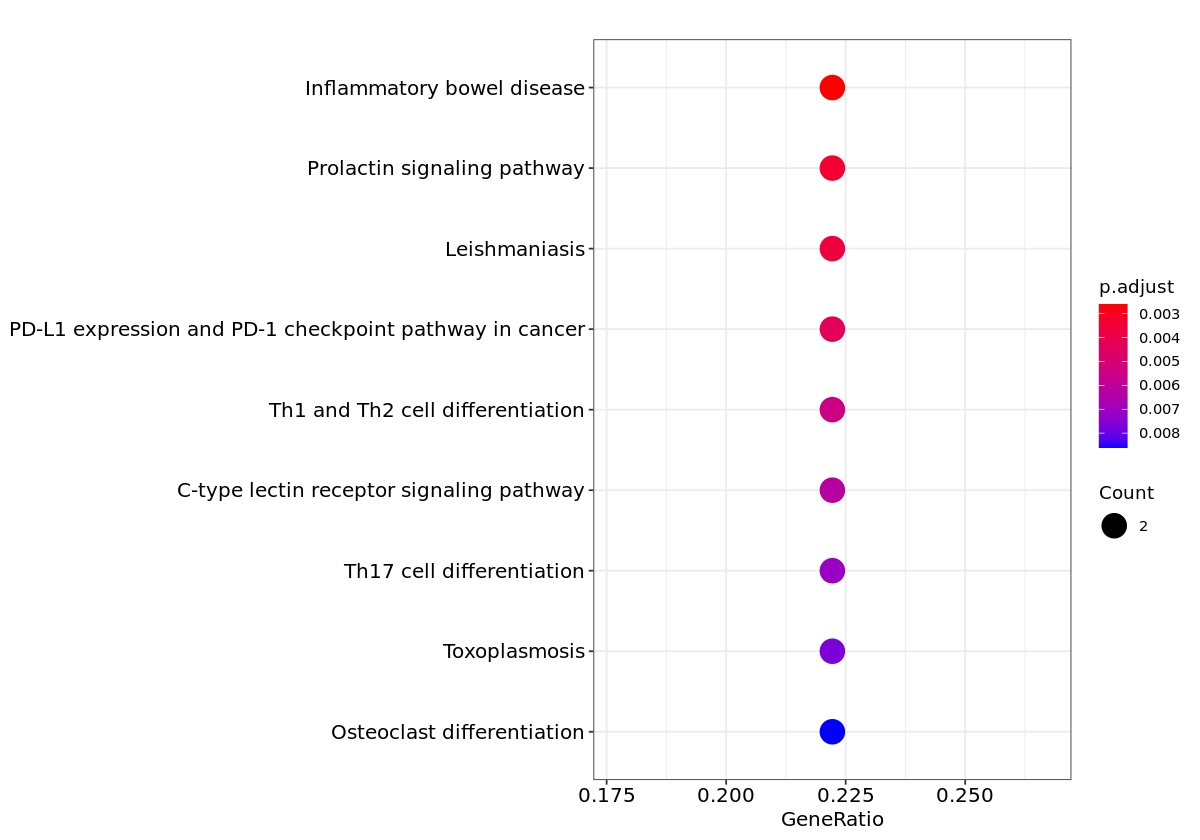

# Code cell n°34

enr_kegg <- pairwise_termsim(enr_kegg, method = "JC", semData = "org.Mm.eg.db")
emapplot(enr_kegg)

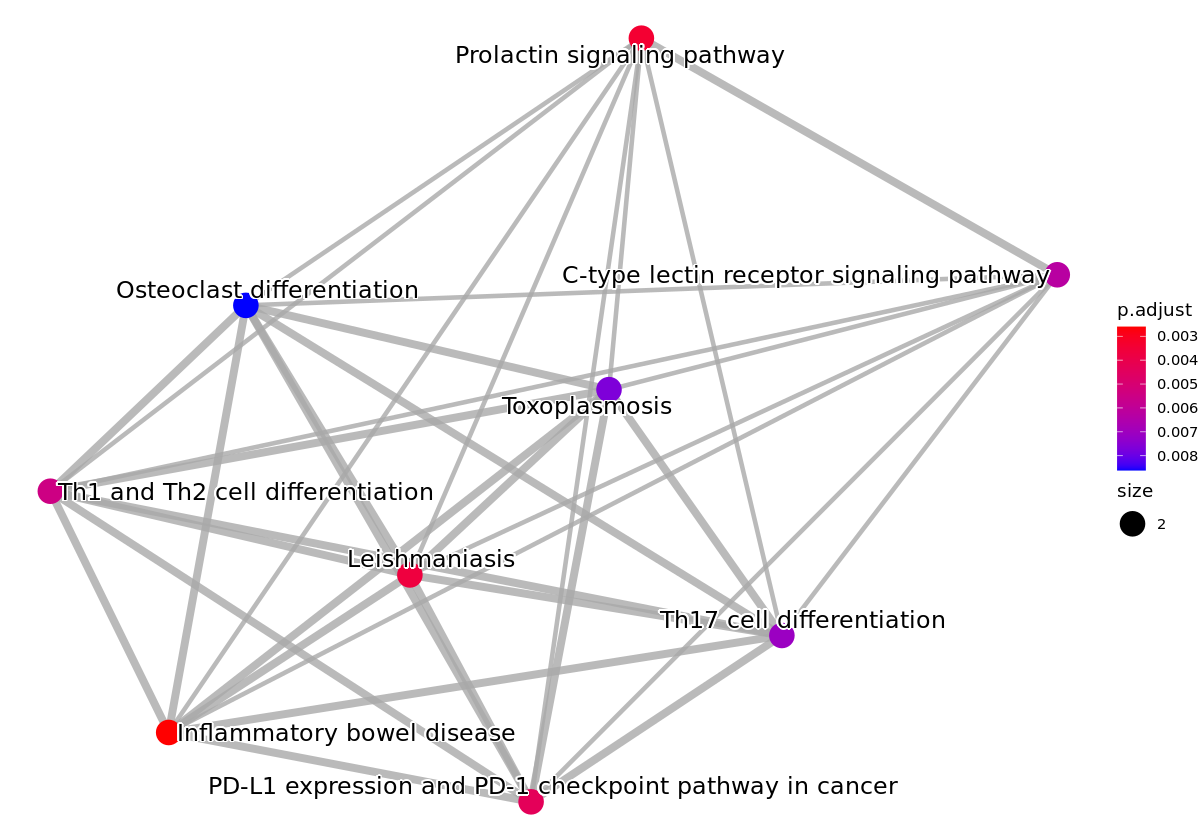

# Code cell n°35

enr_kegg2 <- setReadable(enr_kegg, OrgDb = "org.Mm.eg.db", "UNIPROT")
cnetplot(enr_kegg2, categorySize="pvalue", showCategory = 5)

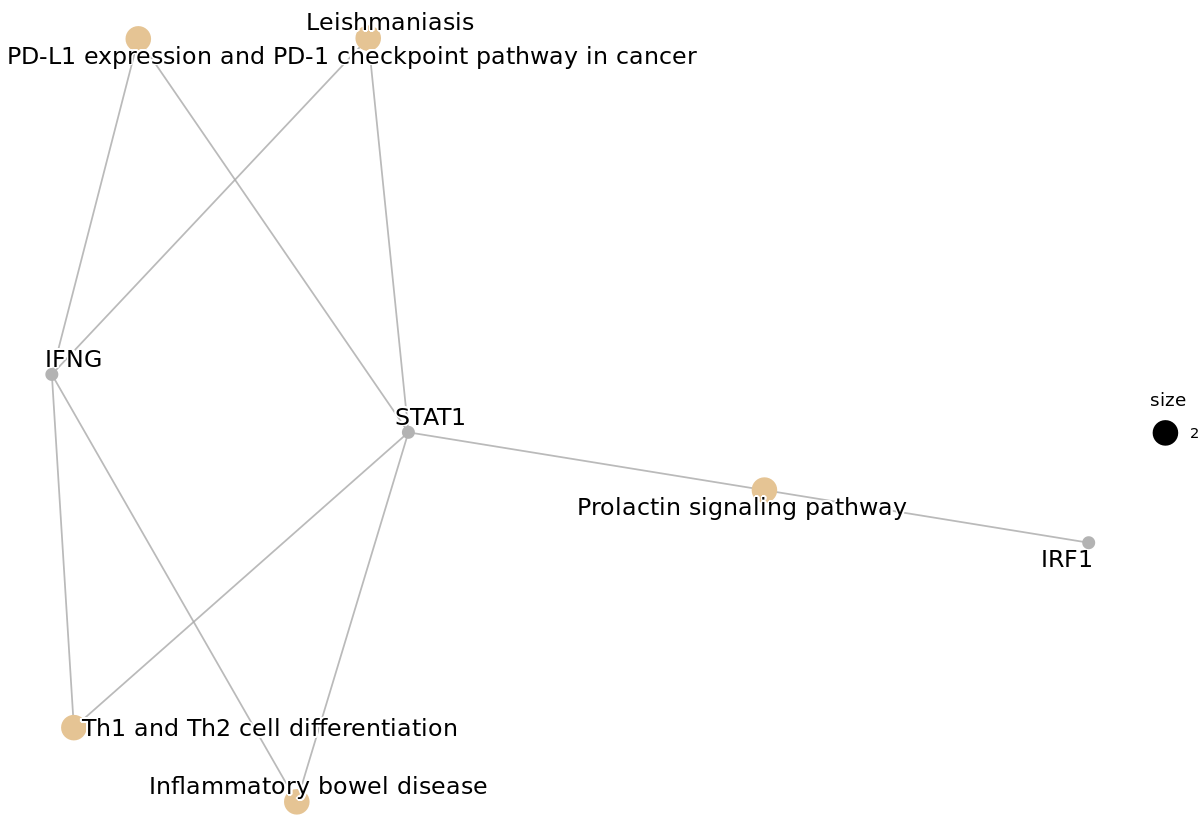

---
### 3.2. GSEA
---

GSEA, standing for Gene Set Enrichment Analysis, is a Significance Analysis of Function and Expression (SAFE) method. While ORAs (over-representation methods) are single-gene approaches, GSEA uses all genes in the dataset and their potential correlation. This method determines whether a pre-defined set of genes (ex: genes belonging to a specific GO term or KEGG pathway) shows statistically significant, concordant differences between two biological states.  
One benefit of GSEA over GO over-representation analysis (i.e hard-filtered DE genes, venn diagrams and hypergeometric tests) is that GSEA does not use arbitrary cutoffs for differential expression significance. GSEA input gene lists do not need to be filtered because genes near the center of the list, meaning a fold-change near 0, are effectively down-weighted to insignificance. 
In addition, it uses quantitative metrics like gene expression or statistics results from a DGE analysis. This later is the most recommended approach to follow, and is known as “pre-ranked GSEA” which takes as input a gene list sorted by a metric of differential expression, commonly either the log2 fold-change or test-statistic.

[GSEA](https://www.gsea-msigdb.org/gsea/index.jsp) was developped at the Broad Institue. The documentation is available [here](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html). It was described in [Subramanian et al. 2005](https://doi.org/10.1073/pnas.0506580102)

We can run a Gene Set Enrichment Aanalysis (GSEA) directly with clusterProfiler. We need first to sort genes by a quantitative metrics, here the statistics of the DGE analysis.


We do it here for example with the Pat versus Control DGE results on GO terms.

In [34]:
# Code cell n°36


mygenes <- sort(mygenes, decreasing = T) 
head(mygenes)

[1] "Zfp992"   "Stag3"    "Spr"      "Sos1"     "Slc39a11" "Slc30a4"

In [35]:
# Code cell n°37

gsea_go <- gseGO(geneList = mygenes, 
             ont ="ALL", 
             keyType = "SYMBOL",
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.25, 
             verbose = TRUE, 
             OrgDb = org.Mm.eg.db, 
             pAdjustMethod = "none",
                 nPerm = 100)    # by default there are 1000 permutations

preparing geneSet collections...

--> Expected input gene ID: Yy1,Lgals9,Chrna7,Cxcl12,Bub3,H2al1i



ERROR: Error in check_gene_id(geneList, geneSets): --> No gene can be mapped....


<mark> It may take a long time and use a lot of memory due to permutations.</mark>

Let's see the result of the top enriched pathway.

In [ ]:
# Code cell n°38

gseaplot2(gsea_go, geneSetID = 1, title = gsea_go$Description[1])

We can also display several patways on the same plot.

In [ ]:
# Code cell n°40

gseaplot2(gsea_go, geneSetID = 1:3, title = "top 3 gene sets", pvalue_table = TRUE,
          color = c("#E495A5", "#86B875", "#7DB0DD"), ES_geom = "dot")

We can also look at the usual figures implemented in clusterProfiler, such as dotplots :

In [ ]:
# Code cell n°41

options(repr.plot.width = 17, repr.plot.height = 10)
dotplot(gsea_go, showCategory=20,
        label_format = function(x) stringr::str_wrap(x, width=  120))+
        ggtitle("dotplot for GSEA")

or emmaplots:

In [ ]:
# Code cell n°42

options(repr.plot.width = 12, repr.plot.height = 7)

gsea_go <- enrichplot::pairwise_termsim(gsea_go, method = "JC", semData = "org.Hs.eg.db")
emapplot(gsea_go, showCategory = 20)

or the cneplots :

Here again, we provide you the commands and results but it does not run on this clusterProfiler version.

<code>options(repr.plot.width=8, repr.plot.height= 8)
    cnetplot(gsea_go, categorySize="pvalue", showCategory = 5)</code>

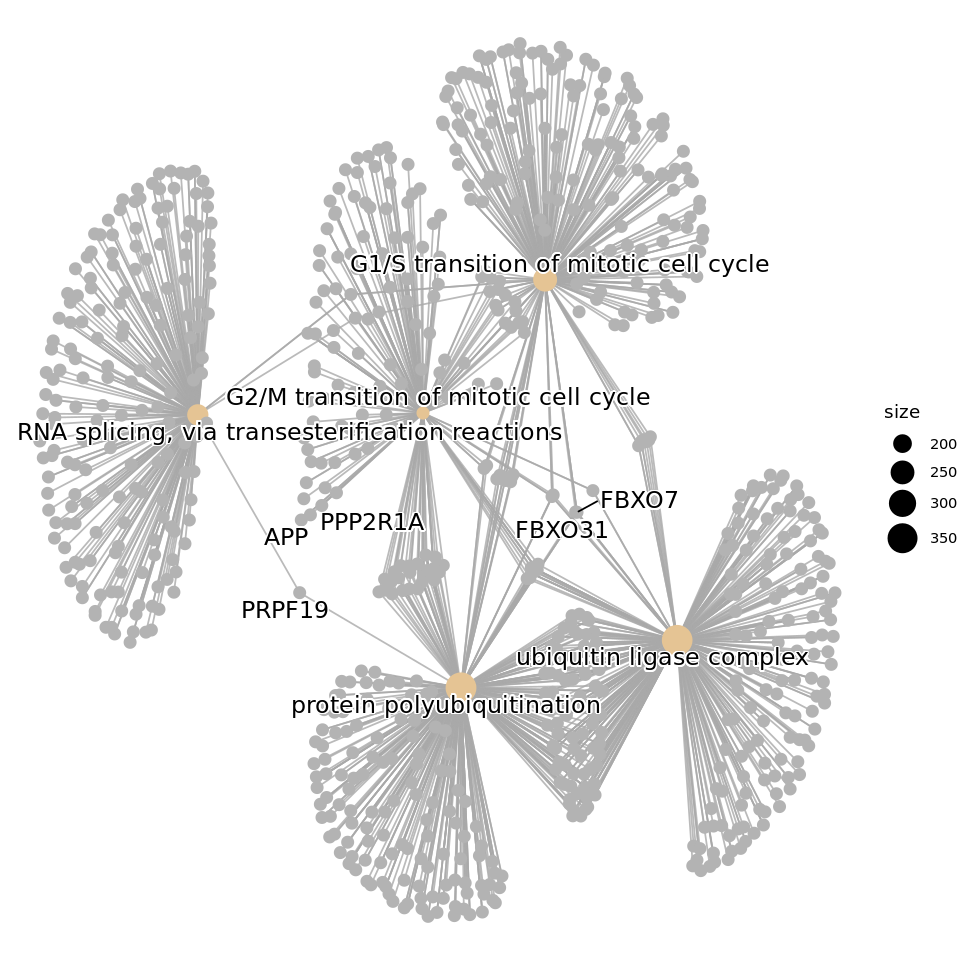


The size of the plot can impact the figure: see the same figure with higher height!

<code>options(repr.plot.width = 13, repr.plot.height = 13)
cnetplot(gsea_go, categorySize="pvalue", showCategory = 5)</code>

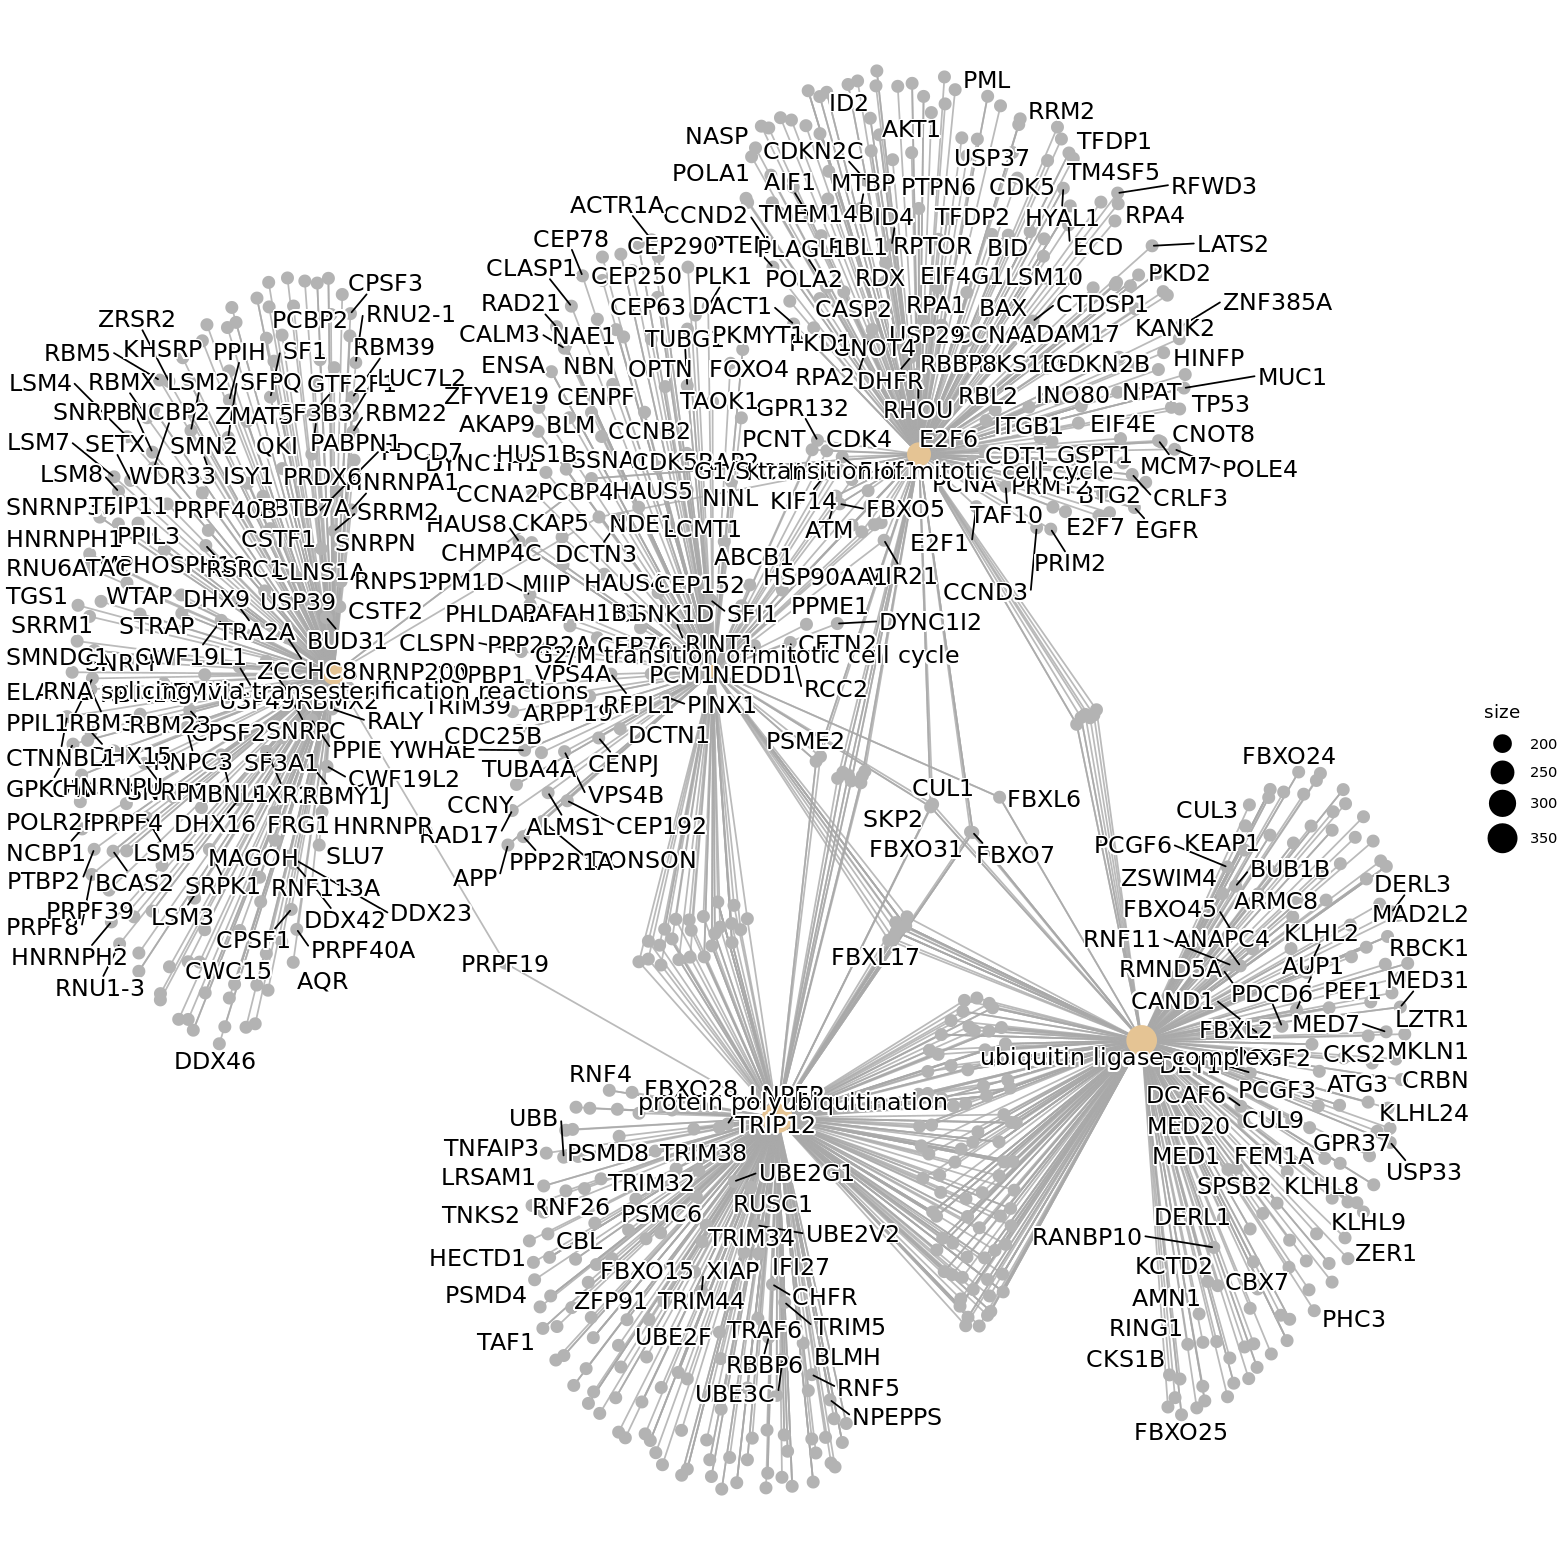

We can also use the **ridgeplot** format which visualizes expression distributions of core enriched genes for GSEA enriched categories. It helps users to interpret up/down-regulated pathways.

In [ ]:
# Code cell n°43

options(repr.plot.width = 30, repr.plot.height = 7)
ridgeplot(gsea_go, label_format = function(x) stringr::str_wrap(x, width=  120))

The x axis is the log2(FC) distribution of genes in pathways. Here all enriched pathways are downregulated!

---
---
## 4. GSEA with the Java application:
---

### 4.1. Preparing input files
---

The GSEA Java application is a stand-alone software to run GSEA on your own computer. 

**Two GSEA methods** are implemented in the Java application:
1. with unranked expression data: GSEA will cluster genes by similarity (different metrics/methods can be used).
2. with pre-ranked expression data: this method is the recommended one. After DGE analysis, we usually upload the data ranked by the statistics, or (and this is equivalent) ranked by the signed pvalue (meaning a positive pvalue when the fold change is positive, a negative pvalue when the fold change is negative).

Whatever the method used, GSEA can only compare two conditions.

GSEA requires **two input files:**
- an expression file
- a phenotype file

***The format for the different inputs is described [here](https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats)***

#### 4.1.A. Expression files:

There are 4 acceptable formats for expression input files: `.gct`, `.res`, `.pcl` and `.txt`. Here we will prepare files in `.txt` format with R. It requires to fill a first column `NAMES` with the names of the genes/probes, followed by a column `DESCRIPTION` that must be with `NA` values (a bug in GSEA requires this column although it is not informative; they will try to fix this issue in a future release), then a column for each sample.

- if we start from normalised unranked values:

We use the `norm.quant` object.

In [ ]:
# Code cell n°44

gsea_T1D_norm.quant <- data.frame("NAMES" = row.names(norm.quant), "DESCRIPTION" = NA, as.data.frame(norm.quant))
names(gsea_T1D_norm.quant)[-(1:2)] <- samples_info$array.labels
str(gsea_T1D_norm.quant)
write.table(gsea_T1D_norm.quant, file="gsea_T1D_norm.quant.txt", sep="\t", col.names = TRUE, quote = FALSE, row.names = FALSE)

- if we start from preranked values: using the signed pvalues

The format is RNK: Ranked list file format (`*.rnk`) 
Here are the command for the 5th contrast as an example. You can do the same for other constrats.

In [ ]:
# Code cell n°45

gsea_T1D_PatVsCont <- data.frame(limma.full.outs[[6]]$ProbeID, limma.full.outs[[6]]$B)
write.table(gsea_T1D_PatVsCont, file="gsea_T1D_PatVsCont.rnk", sep="\t", col.names = FALSE, quote = FALSE, row.names = FALSE)

#### 4.1.B. Phenotype files:

The format `.cls` format is the one for phenotypes.

1. On the first line, you specify 3 values separated by spaces:
- the number of samples
- the number of classes (or levels of your factor of interest)
- 1: always, don't change it

2. On the second line, you put names for each class as they will appear in analysis report. The line should begin with a hashtag sign (#) followed by a space.

3. The third line contains a class label for each sample. The class label can be the class name, a number, or a text string. The first label used is assigned to the first class named on the second line; the second unique label is assigned to the second class named; and so on. The number of class labels specified on this line should be the same as the number of samples specified in the first line. The number of unique class labels specified on this line should be the same as the number of classes specified in the first line.

Here, we will prepare two phenotype files.

- You can prepare one phenotype file per contrast of interest as for example between patients and controls (whathever the stimulus):

In [ ]:
# Code cell n°46

temp <- samples_info$Status
temp <- ifelse(temp == 2, "PAT", "CONT")
gsea_pheno_PatVsCont <- file("gsea_pheno_PatVsCont.cls")
my_text <- paste("264 2 1\n#PAT CONT\n", paste(temp, collapse=" "))
writeLines(my_text, gsea_pheno_PatVsCont)
close(gsea_pheno_PatVsCont)
rm(temp)

You should see the `gsea_pheno_PatVsCont` file in the left column. Open it to see its structure.

- You can also prepare a phenotype file with all groups depending on status and stimulus: g.1.0, g.1.6, g.1.24, g.2.0, g.2.6, g.2.24:

In [ ]:
# Code cell n°47

str(samples_info)

In [ ]:
# Code cell n°48

temp <- samples_info$Status
temp <- ifelse(temp == 2, "PAT", "CONT")
temp <- paste(temp, samples_info$Stim, sep = "")
temp

In [ ]:
# Code cell n°49

gsea_pheno_groups <- file("gsea_pheno_groups.cls")
my_text <- paste("264 6 1\n#PAT0 PAT6 PAT24 CONT0 CONT6 CONT24\n", paste(temp, collapse=" "))
writeLines(my_text, gsea_pheno_PatVsCont)
close(gsea_pheno_groups)

---
### 4.2. Running GSEA (Java Stand-Alone Application)
---

You are ready to run your first GSEA analyses!

Download the Java application from [here](http://www.gsea-msigdb.org/gsea/downloads.jsp) with the appropriate version for your OS. Unzip the downloaded file and launch GSEA by double-clicking on `gsea.bat` if you are on Windows, by double-clicking on the App or on the `gsea.command` if you are on macOS, or by typing the command `./gsea.sh` if you are on Linux or on macOS.

In File>Preferences, specify the directoty where you want the GSEA results to be saved. By default it is in your home repository `/gsea_home/output`.

Click on `Load Data` and upload the different input files. No error must be reported if your formats are correct.

#### <u>4.2.A. If you are using the **method with unranked values**:</u>

- Click on **Run GSEA**

- Select the correct in **Required fields** the correct filed and parameters:
    - `gsea_T1D_norm.quant.txt` for the expression dataset
    - choose the gene set database of interest
    - start with keeping 1000 permutations: if you have pvalues displayed at 0, then rerun the analysis increasing the number of permutations
    - for phenotype labels, select one of the `.cls` file and the contrast of interest
    - keep the option `collapse` to deal with several probes for the same gene
    - choose `phenotype` for permutation if you have several samples per category (7 are recommanded), otherwise select `gene_set` but the statistical test will not be able to account for putative correlations between genes.
    - select here `Human_ILLUMINA_Array_MSigDB.v2022.1.Hs.chip` since we are working with Illumina array data and we kept the probeID identifiers. Should you be working with unique gene symbols, select the `HGNC` platform.<br>
<br>
- In **Basic fields** enter a useful name for your analysis and select a method to rank genes. You can also specify the output folder name.

- Click on **Run** at the bottom.

- You can then run a **Leading edge** analysis and vizualize enrichment map. The enrichment outputs can also be imported to `Cytoscape` using the Cytoscape app `EnrichmentMap`.
    
#### <u>4.2.B. If you are using the **method with pre-ranked values**:</u>

- Click on **Run GSEAPreranked**

- Select in **Required fileds** the correct files and parameters:<br>
    - choose the gene set database of interest
    - start with keeping 1000 permutations: if you have pvalues displayed at 0, then rerun the analysis by increasing the number of permutations
    - for the ranked list, select for example `gsea_T1D_PatVsCont.rbk`
    - keep the option `collapse` to deal with several probes for the same gene
    - select here `Human_ILLUMINA_Array_MSigDB.v2022.1.Hs.chip` since we are working with Illumina array data and we kept the probeID identifiers. Should you be working with unique gene symbols, select the `HGNC` platform.<br>
<br>
- In **Basic fields** enter a useful name for your analysis and select a method to rank genes. You can also specify the output folder name.


<div class="alert alert-block alert-success"><b>Well done:</b>
If your analysis was succesfull, you see <code>Success</code> in green in the "GSEA Reports" frame on the left panel.  Just click on <code>Success</code> to look at the results. Follow the <a href=https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html>guide</a> to understand the outputs. A FDR of 25% is the minimum required to consider a significant enrichment.
</div>

>***Note: GSEA in R:***
>- an R package exists to run GSEA: [GSEABase](https://bioconductor.org/packages/release/bioc/html/GSEABase.html)
>- the package clusterProfiler also implements GSEA (see part 3.2 of this tutorial) and even a fastest approach (fgsea).

---
---

---
### 5. WGCNA 
---

WGCNA begins with the understanding that the information captured by expression experiments is far richer than a list of differentially expressed genes.    
Rather, expression data are more completely represented by considering the relationships between measured transcripts, which can be assessed by pair-wise correlations between gene expression profiles. In most microarray data analyses, however, these relationships go essentially unexplored. WGCNA starts from the level of thousands of genes, identifies clinically interesting gene modules, and finally uses intramodular connectivity, gene significance (e.g. based on the correlation of a gene expression profile with a sample trait) to identify key genes in the disease pathways for further validation. WGCNA alleviates the multiple testing problem inherent in microarray data analysis. Instead of relating thousands of genes to a microarray sample trait, it focuses on the relationship between a few (typically less than 10) modules and the sample trait. Toward this end, it calculates the eigengene significance (correlation between sample trait and eigengene) and the corresponding p-value for each module. The module definition does not make use of a priori defined gene sets. Instead, modules are constructed from the expression data by using hierarchical clustering. Although it is advisable to relate the resulting modules to gene ontology information to assess their biological plausibility, it is not required. Because the modules may correspond to biological pathways, focusing the analysis on intramodular hub genes (or the module eigengenes) amounts to a biologically motivated data reduction scheme. Because the expression profiles of intramodular hub genes are highly correlated, typically dozens of candidate biomarkers result. Although these candidates are statistically equivalent, they may differ in terms of biological plausibility or clinical utility. Gene ontology information can be useful for further prioritizing intramodular hub genes.